In [1]:
%matplotlib inline
import networkx as nx
from collections import defaultdict
import random
import bisect
import copy
N=200
m=4
B=0.5
H=0.1
pseeds=0.2

In [2]:
def homophilic_barabasi_albert_graph(N, m, minority_fraction, similitude):
    """Return homophilic random graph using BA preferential attachment model.

    A graph of n nodes is grown by attaching new nodes each with m
    edges that are preferentially attached to existing nodes with high
    degree. The connections are established by linking probability which 
    depends on the connectivity of sites and the similitude (similarities).
    similitude varies ranges from 0 to 1.

    Parameters
    ----------
    N : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).

    minority_fraction : float
        fraction of minorities in the network

    similitude: float
        value between 0 to 1. similarity between nodes. if nodes have same attribute
        their similitude (distance) is smaller.

    Returns
    -------
    G : Graph

    Notes
    -----
    The initialization is a graph with with m nodes and no edges.

    References
    ----------
    .. [1] A. L. Barabasi and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    G = nx.Graph()

    minority = int(minority_fraction * N)

    minority_nodes = random.sample(range(N), minority)
    node_attribute = {}
    for n in range(N):
        if n in minority_nodes:
            G.add_node(n, color='red')
            node_attribute[n] = 'minority'
        else:
            G.add_node(n, color='blue')
            node_attribute[n] = 'majority'

    # create homophilic distance ### faster to do it outside loop ###
    dist = defaultdict(int)  # distance between nodes

    for n1 in range(N):
        n1_attr = node_attribute[n1]
        for n2 in range(N):
            n2_attr = node_attribute[n2]
            if n1_attr == n2_attr:
                dist[(n1, n2)] = 1 - similitude  # higher similarity, lower distance
            else:
                dist[(n1, n2)] = similitude

    target_list = list(range(m))
    source = m  # start with m nodes

    while source < N:
        targets = _pick_targets(G, source, target_list, dist, m)

        if targets != set():  # if the node does  find the neighbor
            G.add_edges_from(zip([source] * m, targets))

        target_list.append(source)
        source += 1

    return G


def _pick_targets(G, source, target_list, dist, m):
    target_prob_dict = {}
    for target in target_list:
        target_prob = (1 - dist[(source, target)]) * (G.degree(target) + 0.00001)
        target_prob_dict[target] = target_prob

    prob_sum = sum(target_prob_dict.values())

    targets = set()
    target_list_copy = copy.copy(target_list)
    count_looking = 0
    if prob_sum == 0:
        return targets  # it returns an empty set

    while len(targets) < m:
        count_looking += 1
        if count_looking > len(G):  # if node fails to find target
            break
        rand_num = random.random()
        cumsum = 0.0
        for k in target_list_copy:
            cumsum += float(target_prob_dict[k]) / prob_sum
            if rand_num < cumsum:
                targets.add(k)
                target_list_copy.remove(k)
                break
    return targets

In [3]:
def info(G):
    print('- attribute_assortativity_coefficient: ',nx.attribute_assortativity_coefficient(G,'color'))
#     #print('- all connectivity: ', nx.all_pairs_node_connectivity(G))
#     print('- edge connectivity: ', nx.edge_connectivity(G))
    print('- node_connectivity: ',nx.node_connectivity(G))
    print('- average node connectivity: ',nx.average_node_connectivity(G))
#     print('- average_degree_connectivity: ',nx.average_degree_connectivity(G))
#     try: print('- minimum_edge_cut: ',len(nx.minimum_edge_cut(G)))
#     except: pass
#     try: print('- minimum_node_cut: ',len(nx.minimum_node_cut(G)))
#     except: pass
#     try: print('- all_node_cuts: ',len(list(nx.all_node_cuts(G))))
#     except: pass
#     print('- bridge_components: ',len(list(nx.algorithms.connectivity.edge_kcomponents.bridge_components(G))))
        
    adc = nx.average_degree_connectivity(G)
    print('- average_degree_connectivity: ',adc)
    
    N = G.number_of_nodes()
    E = G.number_of_edges()
    rr = len([1 for e in G.edges() if G.node[e[0]]['color']==G.node[e[1]]['color'] and G.node[e[0]]['color']=='red'])
    bb = len([1 for e in G.edges() if G.node[e[0]]['color']==G.node[e[1]]['color'] and G.node[e[0]]['color']=='blue'])
    rb = len([1 for e in G.edges() if G.node[e[0]]['color']!=G.node[e[1]]['color'] and (G.node[e[0]]['color']=='red' or G.node[e[1]]['color']=='red')])

    print('N:{} | E:{}'.format(N,E))
    print('rr: {} ({:.2f}) | bb:{} ({:.2f})'.format(rr,rr/E,bb,bb/E))
    print('homo: {} ({:.2f}) | hetero: {} ({:.2f})'.format((rr+bb),(rr+bb)/E,rb,rb/E))
    print(nx.info(G))
    
    #colors = list(nx.get_node_attributes(G,'color').values())
    #nx.draw_networkx(G, node_color=colors, pos=nx.circular_layout(G))
    return adc

In [4]:
g_hete = homophilic_barabasi_albert_graph(N=N, m=m, minority_fraction=B, similitude=H)
g_homo = homophilic_barabasi_albert_graph(N=N, m=m, minority_fraction=B, similitude=1-H)

In [5]:
hete_dc = info(g_hete)

- attribute_assortativity_coefficient:  -0.7525538716841156
- node_connectivity:  3
- average node connectivity:  5.153969849246232
- average_degree_connectivity:  {3: 18.333333333333332, 29: 10.568965517241379, 26: 9.038461538461538, 31: 13.225806451612904, 38: 12.921052631578947, 37: 13.324324324324325, 25: 14.08, 44: 9.909090909090908, 32: 10.84375, 24: 14.25, 13: 11.679487179487179, 14: 11.964285714285714, 12: 14.041666666666666, 22: 11.363636363636363, 9: 14.428571428571429, 11: 13.977272727272727, 7: 13.047619047619047, 18: 9.583333333333334, 19: 11.736842105263158, 10: 11.845454545454546, 16: 13.375, 6: 16.130434782608695, 15: 9.333333333333334, 8: 11.625, 5: 13.315, 4: 15.62295081967213}
N:200 | E:784
rr: 48 (0.06) | bb:49 (0.06)
homo: 97 (0.12) | hetero: 687 (0.88)
Name: 
Type: Graph
Number of nodes: 200
Number of edges: 784
Average degree:   7.8400


In [6]:
homo_dc = info(g_homo)

- attribute_assortativity_coefficient:  0.7576526669432446
- node_connectivity:  4
- average node connectivity:  5.154221105527638
- average_degree_connectivity:  {23: 14.826086956521738, 27: 10.592592592592593, 10: 10.7875, 25: 12.84, 43: 12.046511627906977, 33: 12.151515151515152, 38: 11.526315789473685, 35: 11.8, 20: 14.4, 29: 9.89655172413793, 21: 13.428571428571429, 13: 11.753846153846155, 17: 10.147058823529411, 15: 14.966666666666667, 9: 11.682539682539682, 22: 10.272727272727273, 12: 13.472222222222221, 18: 11.777777777777779, 7: 14.628571428571428, 19: 10.157894736842104, 11: 9.5, 14: 7.571428571428571, 8: 12.534090909090908, 5: 13.092682926829267, 6: 14.324074074074074, 4: 16.11904761904762, 16: 10.375}
N:200 | E:784
rr: 344 (0.44) | bb:345 (0.44)
homo: 689 (0.88) | hetero: 95 (0.12)
Name: 
Type: Graph
Number of nodes: 200
Number of edges: 784
Average degree:   7.8400


In [7]:
# hete_dc = {13: 10.596153846153847, 25: 12.52, 12: 12.483333333333333, 32: 11.21875, 27: 11.518518518518519, 41: 11.536585365853659, 10: 11.830769230769231, 18: 14.444444444444445, 15: 12.12, 28: 9.964285714285714, 24: 13.833333333333334, 9: 12.88888888888889, 16: 14.25, 22: 8.977272727272727, 19: 10.31578947368421, 14: 12.339285714285714, 8: 11.828125, 21: 8.619047619047619, 6: 12.591666666666667, 11: 11.204545454545455, 5: 12.122222222222222, 7: 12.107142857142858, 4: 13.833333333333334}
# homo_dc = {14: 11.803571428571429, 21: 13.738095238095237, 27: 10.666666666666666, 41: 10.024390243902438, 36: 11.583333333333334, 20: 15.9, 35: 10.428571428571429, 22: 12.136363636363637, 9: 12.19047619047619, 26: 12.076923076923077, 11: 12.193181818181818, 24: 11.027777777777779, 34: 10.735294117647058, 25: 10.56, 10: 12.48, 5: 15.372222222222222, 12: 13.25, 18: 9.944444444444445, 6: 14.041666666666666, 8: 12.159090909090908, 7: 12.80451127819549, 4: 14.73360655737705}
print(hete_dc.values())

dict_values([18.333333333333332, 10.568965517241379, 9.038461538461538, 13.225806451612904, 12.921052631578947, 13.324324324324325, 14.08, 9.909090909090908, 10.84375, 14.25, 11.679487179487179, 11.964285714285714, 14.041666666666666, 11.363636363636363, 14.428571428571429, 13.977272727272727, 13.047619047619047, 9.583333333333334, 11.736842105263158, 11.845454545454546, 13.375, 16.130434782608695, 9.333333333333334, 11.625, 13.315, 15.62295081967213])


Text(0.5,1,'average_degree_connectivity')

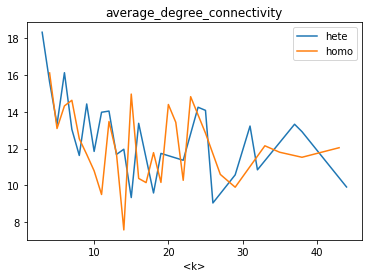

In [8]:
import pandas as pd
df_hete = pd.Series(list(hete_dc.values()),index=list(hete_dc.keys()))
df_hete.sort_index(inplace=True)
df_hete.index.name = '<k>'
ax=df_hete.plot(label='hete')
ax.legend()
ax.set_title('average_degree_connectivity')
df_homo = pd.Series(list(homo_dc.values()),index=list(homo_dc.keys()))
df_homo.sort_index(inplace=True)
df_homo.index.name = '<k>'
ax=df_homo.plot(label='homo')
ax.legend()
ax.set_title('average_degree_connectivity')

In [9]:
import numpy as np
import matplotlib.pyplot as plt 

def sample_stats(g,p=0.1,times=5):
    nodes = list(g.nodes())
    nnodes = int(round(len(nodes) * p))
    unlabeled = len(nodes) - nnodes
    print('sample size:{} | unlabelled:{} | N:{} | E:{}'.format(nnodes,unlabeled,g.number_of_nodes(),g.number_of_edges()))
    samples = []
    df = pd.DataFrame(index=range(unlabeled), columns=range(times))
    
    for i in range(5):
        np.random.shuffle(nodes)
        sample = np.random.choice(nodes,nnodes,replace=False)
        unlabelled = [n for n in nodes if n not in sample]
        neighbors_seeds = [round(sum([1 for m in list(g[n]) if m in sample])/float(len(list(g[n]))),1) for n in unlabelled]
        df[i] = neighbors_seeds
        samples.append(sample)
        
    # per node
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    maxi = df.max(axis=0).max()
    mini = df.min(axis=0).min()
    ax = df.plot(ylim=(mini,maxi),legend=True,title='proportion of neighbor-seeds (mean {:.2f}, min {:.2f}, max {:.2f})'.format(mean.mean(),mini,maxi),subplots=True,layout=(times,1))
    for i in range(times):
        ax[i,0].axhline(mean[i],lw=0.5,color='grey')

    return df,samples

def distribution_proportion_seeds(df):
    # distribution
    times = len(df.columns)
    for i in range(times):
        ax=pd.value_counts(df[i]).sort_index().plot(legend=True)
        ax.set_xlabel('% neighbors that are seeds')
        ax.set_ylabel('# unlabeled nodes')


sample size:40 | unlabelled:160 | N:200 | E:784


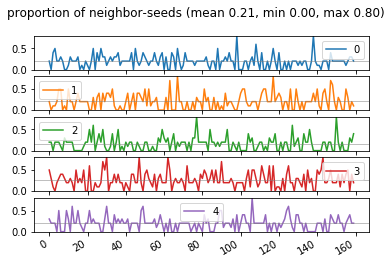

In [10]:
proportionseeds_hete, samples_hete = sample_stats(g_hete,p=pseeds)

sample size:40 | unlabelled:160 | N:200 | E:784


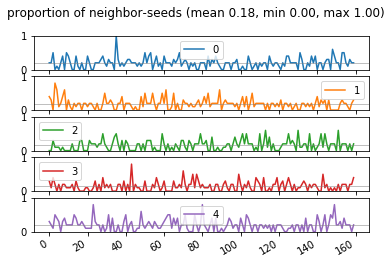

In [11]:
proportionseeds_homo, samples_homo = sample_stats(g_homo,p=pseeds)

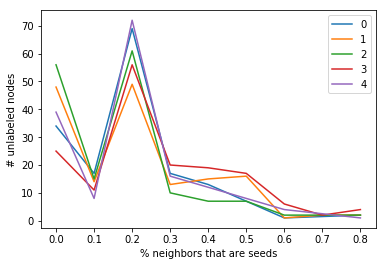

In [12]:
distribution_proportion_seeds(proportionseeds_hete)

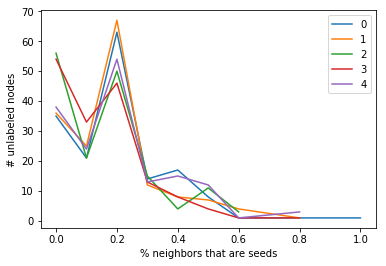

In [13]:
distribution_proportion_seeds(proportionseeds_homo)

In [14]:
def mean_degree_neighborhood(g):
    d = nx.average_neighbor_degree(g)
    
    nodes = list(g.nodes())
    df = pd.DataFrame([d[n] for n in nodes],index=nodes,columns=['all'])
    df.index.name = 'node id'
    ax=df.plot(legend=True,layout=(1,3),color='black')
    ax.axhline(df.mean().values[0],linewidth=0.5,color='black')
    ax.set_ylabel('mean degree neighborhood')
    
    nodes = [n for n in g.nodes() if g.node[n]['color']=='red']
    df = pd.DataFrame([d[n] for n in nodes],index=nodes,columns=['red'])
    df.index.name = 'node id'
    df.plot(legend=True,ax=ax,color='red')
    ax.axhline(df.mean().values[0],linewidth=0.5,color='red')
    ax.set_ylabel('mean degree neighborhood')
    
    nodes = [n for n in g.nodes() if g.node[n]['color']=='blue']
    df = pd.DataFrame([d[n] for n in nodes],index=nodes,columns=['blue'])
    df.index.name = 'node id'
    ax = df.plot(legend=True,ax=ax,color='blue')
    ax.axhline(df.mean().values[0],linewidth=0.5,color='blue')
    ax.set_ylabel('mean degree neighborhood')
        

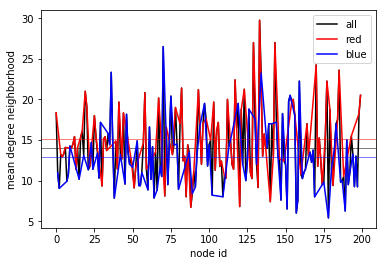

In [15]:
mean_degree_neighborhood(g_hete)

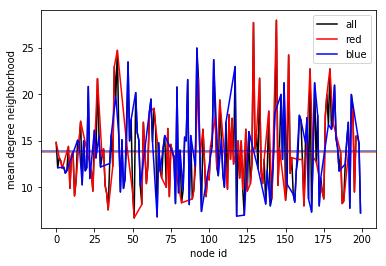

In [16]:
mean_degree_neighborhood(g_homo)

In [17]:
def neighborhood(g,samples):
    times = len(samples)
    
    subgraphs = []
    lengthpaths = []
    for i,sample in enumerate(samples):
        #unlabeled
        unlabelled = [n for n in g.nodes() if n not in sample]
        neighbors_seeds = [round(sum([1 for m in list(g[n]) if m in sample])/float(len(list(g[n]))),1) for n in unlabelled]
        s = pd.Series(neighbors_seeds, index=unlabelled)
        s = s.loc[s == 0] #unlabeled nodes connected with no seeds
        
        #subgraph only with unlabeled with no seed as neighbor
        subg = g.subgraph(list(s.index))
        print(nx.info(subg))
        
        subgraphs.append(subg)
        
        # length path from each unlabeled nodes connected with no seeds
        lengths = [len(list(nx.dfs_edges(subg,n))) for n in s.index]
        t = pd.Series(lengths,index=s.index)
        t.sort_values(inplace=True)
        lengthpaths.append( (t) )
    return subgraphs, lengthpaths
        

In [18]:
sghete, phete = neighborhood(g_hete,samples_hete)

Name: 
Type: SubGraph
Number of nodes: 34
Number of edges: 7
Average degree:   0.4118
Name: 
Type: SubGraph
Number of nodes: 48
Number of edges: 27
Average degree:   1.1250
Name: 
Type: SubGraph
Number of nodes: 56
Number of edges: 53
Average degree:   1.8929
Name: 
Type: SubGraph
Number of nodes: 25
Number of edges: 2
Average degree:   0.1600
Name: 
Type: SubGraph
Number of nodes: 39
Number of edges: 25
Average degree:   1.2821


In [19]:
sghomo, phomo = neighborhood(g_homo,samples_homo)

Name: 
Type: SubGraph
Number of nodes: 35
Number of edges: 12
Average degree:   0.6857
Name: 
Type: SubGraph
Number of nodes: 36
Number of edges: 11
Average degree:   0.6111
Name: 
Type: SubGraph
Number of nodes: 56
Number of edges: 52
Average degree:   1.8571
Name: 
Type: SubGraph
Number of nodes: 54
Number of edges: 18
Average degree:   0.6667
Name: 
Type: SubGraph
Number of nodes: 38
Number of edges: 18
Average degree:   0.9474


In [20]:
def plot_unlabeled_subgraphs(graphs):
    times = len(graphs)
    f, axarr = plt.subplots(times,sharex=True, sharey=True,figsize=(10,15))
    
    for i,subgraph in enumerate(graphs):
        colors = list(nx.get_node_attributes(subgraph,'color').values())
        nx.draw_networkx(subgraph, node_color=colors, pos=nx.spring_layout(subgraph), ax = axarr[i], with_labels=False)

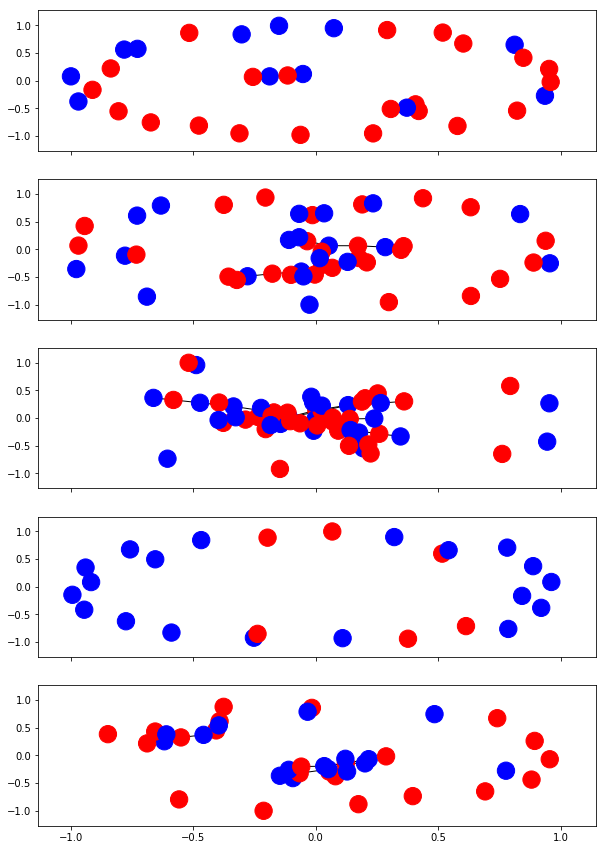

In [21]:
plot_unlabeled_subgraphs(sghete)

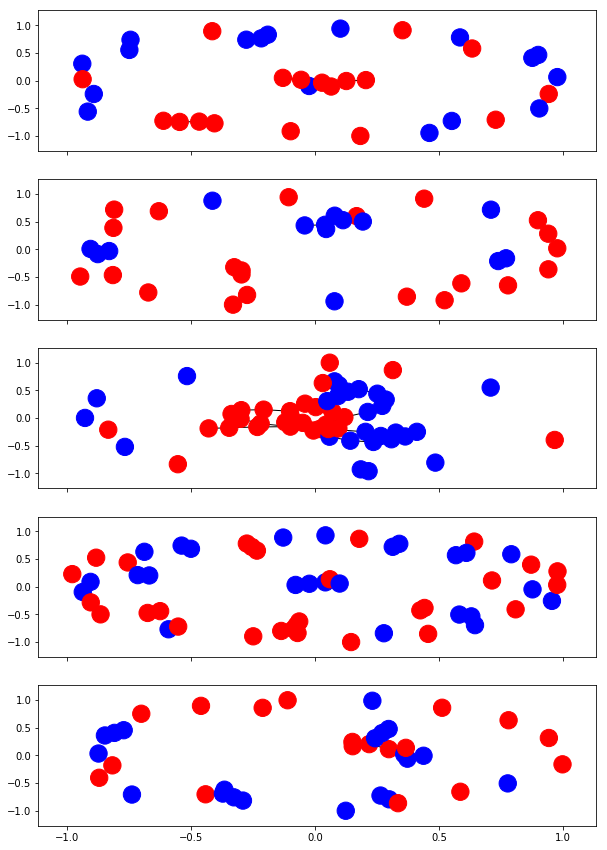

In [22]:
plot_unlabeled_subgraphs(sghomo)

In [23]:
def plot_legth_path_unlabeled(paths):
    times = len(paths)
    f, axarr = plt.subplots(times,figsize=(10,15))
    
    for i,p in enumerate(paths):
        tmp = pd.value_counts(p).sort_index()
        tmp.plot.bar(legend=True,sharex=False,sharey=False,ax=axarr[i])
        axarr[i].set_xlabel('path length')
        axarr[i].set_ylabel('#unlabeled nodes') #connected with no seeds

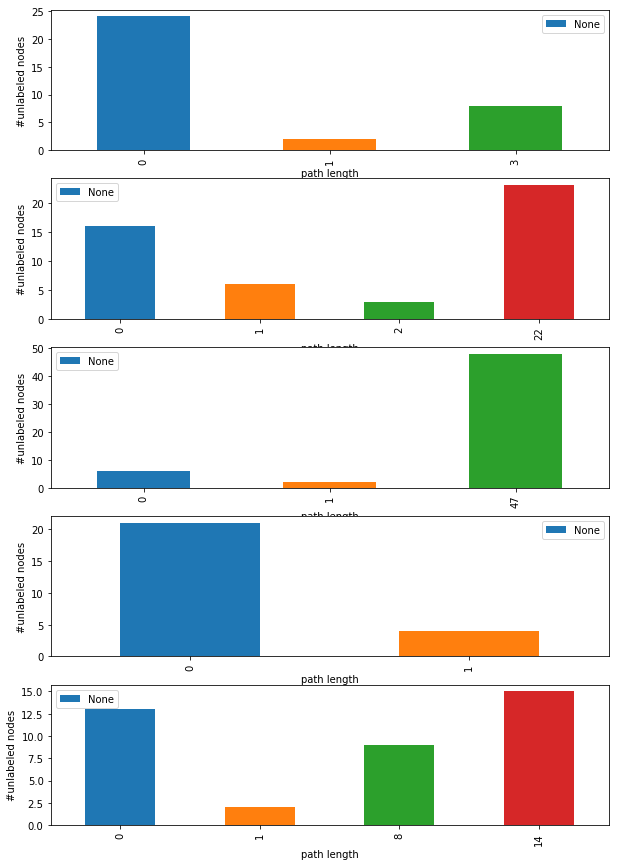

In [24]:
plot_legth_path_unlabeled(phete)

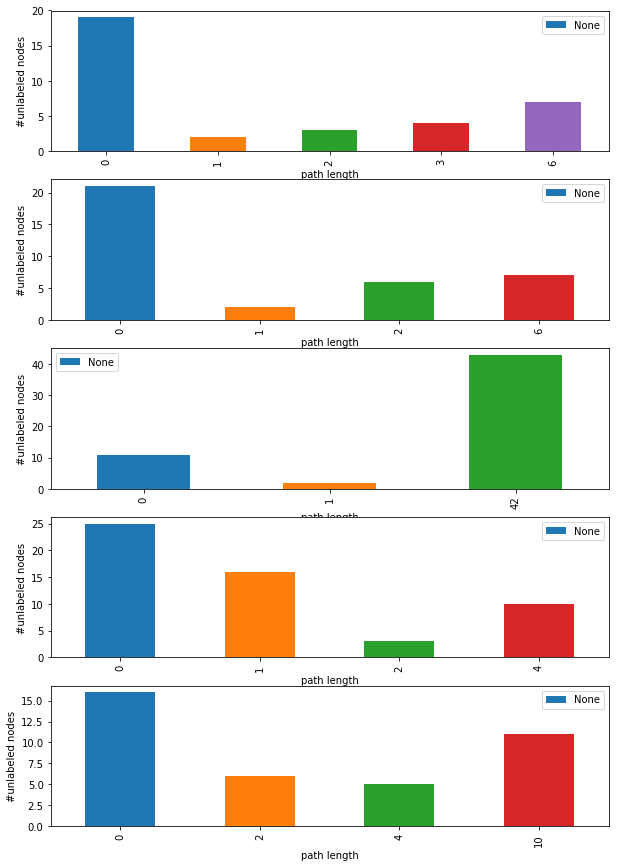

In [25]:
plot_legth_path_unlabeled(phomo)

In [26]:
from scipy.sparse import csr_matrix
import seaborn as sns

def distance_to_seed(g,samples):
    times = len(samples)
    cmap = sns.cm.rocket_r
    
    f, axarr = plt.subplots(times,figsize=(10,15))
    for i,sample in enumerate(samples):
        unlabelled = [n for n in g.nodes() if n not in sample]
        data = csr_matrix((len(unlabelled),len(sample)))
        
        for r,un in enumerate(unlabelled):
            for c,s in enumerate(sample):

                try:
                    d = nx.shortest_path_length(g,un,s)
                except:
                    d = None
                 
                if d is None or d == 0:
                    continue
                else:
                    data[r,c] = d
        
        
        df = pd.DataFrame(data.todense(),index=unlabelled, columns=sample)
        df.index.name = 'unlabeled_nodes'
        df.columns.name = 'seed_nodes'
        sns.heatmap(df, annot=False, cmap=cmap, ax=axarr[i])

/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


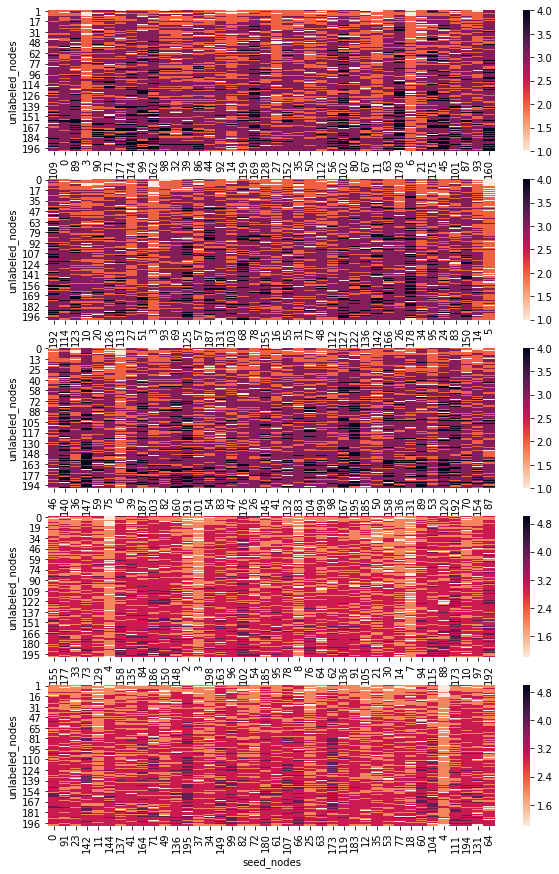

In [27]:
distance_to_seed(g_hete,samples_hete)

/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


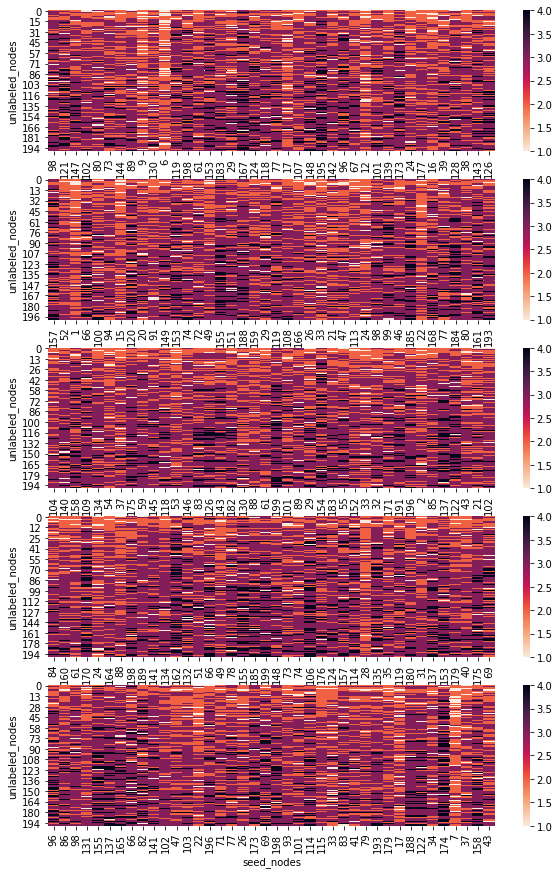

In [28]:
distance_to_seed(g_homo,samples_homo)

In [29]:
from collections import Counter
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))

def get_distances(samples,g):
    times = len(samples)
    
    columns = ['node1','color1','node2','color2','homophily','typelink','distance']
    distances = []
    
    for i,sample in enumerate(samples):
        
        data = pd.DataFrame(columns=columns)
        
        for node1 in g.nodes():
                for node2 in g.nodes():

                    if node1 in sample and node2 in sample:
                        typelink = 'seed-seed'
                    elif node1 not in sample and node2 not in sample:
                        typelink = 'unlabeled-unlabeled'
                    else:
                        typelink = 'unlabeled-seed'

                    color1 = g.node[node1]['color']
                    color2 = g.node[node2]['color']

                    if color1 != color2:
                        homophily = 'heterophilic'
                    else:
                        homophily = 'homophilic'

                    try:
                        distance = nx.shortest_path_length(g,node1,node2)
                    except:
                        distance = None

                    if distance is None or distance == 0:
                        continue
                    else:
                        distance = float(distance)
                        data = data.append(pd.DataFrame([[node1,color1,node2,color2,homophily,typelink,distance]], columns=columns), ignore_index=True)
            
        print(data.head(5))
        distances.append(data)
            
    return distances

In [30]:
 distances_hete = get_distances(samples_hete,g_hete)

  node1 color1 node2 color2     homophily        typelink  distance
0     0    red     1   blue  heterophilic  unlabeled-seed       2.0
1     0    red     2   blue  heterophilic  unlabeled-seed       2.0
2     0    red     3    red    homophilic       seed-seed       2.0
3     0    red     4    red    homophilic  unlabeled-seed       1.0
4     0    red     5    red    homophilic  unlabeled-seed       2.0
  node1 color1 node2 color2     homophily             typelink  distance
0     0    red     1   blue  heterophilic  unlabeled-unlabeled       2.0
1     0    red     2   blue  heterophilic  unlabeled-unlabeled       2.0
2     0    red     3    red    homophilic       unlabeled-seed       2.0
3     0    red     4    red    homophilic  unlabeled-unlabeled       1.0
4     0    red     5    red    homophilic       unlabeled-seed       2.0
  node1 color1 node2 color2     homophily             typelink  distance
0     0    red     1   blue  heterophilic  unlabeled-unlabeled       2.0
1     0 

In [31]:
 distances_homo = get_distances(samples_homo,g_homo)

  node1 color1 node2 color2     homophily             typelink  distance
0     0    red     1   blue  heterophilic  unlabeled-unlabeled       2.0
1     0    red     2    red    homophilic  unlabeled-unlabeled       2.0
2     0    red     3    red    homophilic  unlabeled-unlabeled       2.0
3     0    red     4    red    homophilic  unlabeled-unlabeled       1.0
4     0    red     5   blue  heterophilic  unlabeled-unlabeled       1.0
  node1 color1 node2 color2     homophily             typelink  distance
0     0    red     1   blue  heterophilic       unlabeled-seed       2.0
1     0    red     2    red    homophilic  unlabeled-unlabeled       2.0
2     0    red     3    red    homophilic  unlabeled-unlabeled       2.0
3     0    red     4    red    homophilic  unlabeled-unlabeled       1.0
4     0    red     5   blue  heterophilic  unlabeled-unlabeled       1.0
  node1 color1 node2 color2     homophily             typelink  distance
0     0    red     1   blue  heterophilic  unlabele

In [32]:
# distance between node1 and node2
# node1 can be seed or not (the same for node2)
# node1 can be blue or red (the same for node2)
# if node1 is the same color of node 2 then it is 'homophilic' otherwise 'heterophilic'
# if node1 and node2 are unlabeled nodes, then this is a unlabeled-unlabeled type
# if node1 and node2 are seed nodes, then this is a seed-seed type
# other whise it is unlabled-seed
def plot_distances_violin(distances):
    times = len(distances)
    f, axarr = plt.subplots(times,figsize=(5,12))
    for i,data in enumerate(distances):
        sns.violinplot(x="typelink", y="distance", hue="homophily", hue_order = ['homophilic','heterophilic'], order=["unlabeled-unlabeled", "unlabeled-seed", "seed-seed"],  data=data, split=True, ax=axarr[i]);

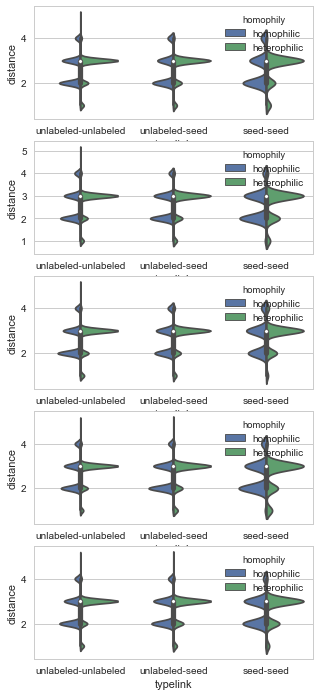

In [33]:
plot_distances_violin(distances_hete)

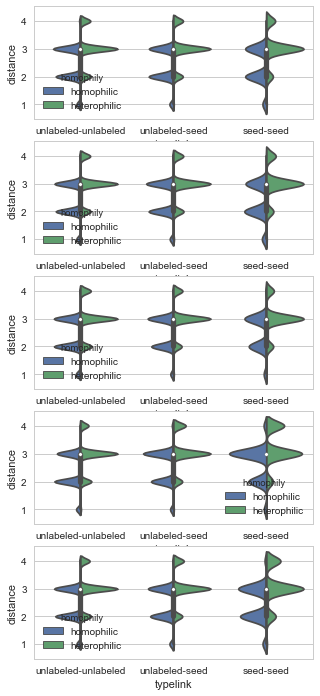

In [34]:
plot_distances_violin(distances_homo)